# Evaluating generated code

Here we will learn to how evaluate the generated NPUEval kernel solutions.

## Goals

* Produce solutions using multiple models (GPT-4o, GPT-4.1)
* Evaluate the and compare the models
* Learn to interpret metrics like functional correctness, cycle count and vectorization score

## Setup for experiments

In [1]:
# Standard imports
from pathlib import Path
import json

# Load the NPUEval dataset and sample the first 5 kernels
from npueval import dataset
tests = dataset[:5]

# List models we want to evaluate
models = ['gpt-4o-mini', 'gpt-4.1']

# Where we'll store solutions and evaluations
results_path = Path("results")

## Generating a single completion

We wrap our code generation into a `generate_one_completion` convenience function. It must return a dict with a code entry and we can use whatever parameterization we want.

```python
def generate_one_completion(prompt, model="gpt-4o-mini", base_url=None, temperature=0.0, top_p=1.0, attempts=1):

    # your implementation
    
    result = {
        "code":  # only code, no markdown!
        "stats": # (optional) generation stats you want to track, e.g. tokens
    }

    return result
```

Note that `code` is the only mandatory field of the returned result. However you can add whatever additional stats you want for later parsing. E.g. if you are using a reasoning model you may want those reasoning traces, or number of iterations, or token usage, price, etc.

Below is a basic implementation using the AIECoder class from the last notebook. It will return the clean extracted C++ code (if there is any) and additional stats like token usage and internal history of the coder.

In [2]:
from npueval.aiecoder import AIECoder

def generate_one_completion(prompt, model="gpt-4o-mini", base_url=None, temperature=0.0, top_p=1.0, attempts=1):
    coder = AIECoder(model=model, temperature=temperature, top_p=top_p, base_url=base_url, attempts=attempts)
    response = coder(prompt)
    
    result = {
        "code": coder.extract_codeblock(response['response']),
        "stats": {"token_usage": response['token_usage'],
                  "history": response['history']}
    }

    return result

## Run completions

Now let's iterate this over the first 5 kernels of the dataset for each model and store each result in a json file.

In [3]:
# For each model generate a solution in the local results path
for model in models:
    print(f"Generating solutions for {model}")
    solutions_path = results_path / "solutions" / model
    solutions_path.mkdir(parents=True, exist_ok=True)
    
    for test in tests:
        print(f"Generating solution for {test['kernel_name']}")
        response = generate_one_completion(test['prompt'], model=model)
        
        solution_file = solutions_path / f"{test['kernel_name']}.json"
        with solution_file.open('w') as file:
            json.dump(response, file, indent=4)

Generating solutions for gpt-4o-mini
Generating solution for abs_int8
Generating solution for add_offset_int8
Generating solution for add_offset_uint8
Generating solution for argmax_bfloat16
Generating solution for argmax_int32
Generating solutions for gpt-4.1
Generating solution for abs_int8
Generating solution for add_offset_int8
Generating solution for add_offset_uint8
Generating solution for argmax_bfloat16
Generating solution for argmax_int32


## Run evaluations

Now that we have a set of kernel solutions for each model we can evaluate them and check how they compare. The `run_function_tests` function abstracts a lot of the individual steps required to compile the kernel, configure the NPU array and run the kernel on the test inputs and outputs.

In [4]:
from npueval import run_functional_tests

for model in models:
    solutions_path = results_path / "solutions" / model
    evals_path = results_path / "evaluations" / model
    run_functional_tests(tests, solutions_path, results_path=evals_path, overwrite=True, verbose=False)


Kernel: abs_int8_wrapper
results/evaluations/gpt-4o-mini/abs_int8_wrapper.mlir generated successfully
abs_int8_wrapper.xclbin, abs_int8_wrapper.bin built
Trace written to results/evaluations/gpt-4o-mini/abs_int8_wrapper_trace.json
Result: Pass

Kernel: add_offset_int8_wrapper
results/evaluations/gpt-4o-mini/add_offset_int8_wrapper.mlir generated successfully
add_offset_int8_wrapper.xclbin, add_offset_int8_wrapper.bin built
Trace written to results/evaluations/gpt-4o-mini/add_offset_int8_wrapper_trace.json
Result: Pass

Kernel: add_offset_uint8_wrapper
results/evaluations/gpt-4o-mini/add_offset_uint8_wrapper.mlir generated successfully
add_offset_uint8_wrapper.xclbin, add_offset_uint8_wrapper.bin built
Trace written to results/evaluations/gpt-4o-mini/add_offset_uint8_wrapper_trace.json
Result: Pass

Kernel: argmax_bfloat16_wrapper
results/evaluations/gpt-4o-mini/argmax_bfloat16_wrapper.mlir generated successfully
argmax_bfloat16_wrapper.xclbin, argmax_bfloat16_wrapper.bin built
Trace w

Can already see that all GPT-4o-mini kernels passed the functional tests at least, whereas GPT-4.1 only passed 2/5.

## Analyze results

Now that we've generated some code and ran the evaluations scripts, how do we determine performance?

### Inspect single kernel

We'll start out by choosing a single kernel and diving into the available results.

In [5]:
import json

kernel = "abs_int8"

# Print the generated kernel source code
with open(solutions_path / f"{kernel}.json") as f:
    data = json.load(f)
    print(data['code'])

#include <aie_api/aie.hpp>
#include <cstdint>

void abs_int8(int8_t *in_buffer, int8_t *out_buffer) {
    constexpr int N = 1024;
    constexpr int VEC = 16; // aie::vector<int8_t, 16>
    for (int i = 0; i < N; i += VEC) {
        aie::vector<int8_t, VEC> vin = aie::load_v<VEC>(in_buffer + i);
        aie::vector<int8_t, VEC> vout = aie::abs(vin);
        aie::store_v(out_buffer + i, vout);
    }
}


### Recorded results

For each kernel we expect the following:
* xdna_info - system info dump, crucially it includes the compiler version to make sure comparisons of different LLMs are fair and influenced by a compiler update
* result - this is the functional test result which will be a Pass or Fail
* stats - tracks absolute/relative errors of kernels, useful for determining the quality of floating point ops
* trace information:
    * total_cycles - how long the kernel ran in clock cycles, this is deterministic between runs
    * vector_cycles - how many cycles was the vector processing unit (VPU) used
    * vector_score - the relative portion of time spent using the VPU (vector_cycles / total_cycles)

In [6]:
with open(evals_path / f"{kernel}_wrapper.json") as f:
    data = json.load(f)
    print(data.keys())

dict_keys(['result', 'stats', 'total_cycles', 'vector_cycles', 'vector_score', 'xdna_info'])


In [7]:
# Each experiment will log build setup - very useful for debug
for key, item in data['xdna_info'].items():
    print(f"{key}: {item}")

device: NPU Phoenix
os: Ubuntu 24.04.2 LTS
kernel: 6.11.0-26-generic
xdna_version: 2.19.0_20250624
xdna_hash: 51b94006f4178016302fcdcbf1d14f48ccfaaf7f
firmware_version: 1.5.4.389
compiler_version: {'version': '19.0.0', 'repo_url': 'https://github.com/Xilinx/llvm-aie', 'commit_hash': 'b2a279c1939604e2ee82a651683dd995decc25ee', 'build_config': ['+assertions']}


In [8]:
# Functional test result
print(data['result'])

Pass


In [9]:
# Extra stats mostly useful for floating point ops
print(data['stats'])

{'max_absolute_error': 0.0, 'max_relative_error': 0.0, 'max_abs_error_idx': 0, 'max_rel_error_idx': 0, 'abs_error_mean': 0.0, 'abs_error_std': 0.0, 'rel_error_mean': 0.0, 'rel_error_std': 0.0}


In [10]:
print(f"total_cycles:  {data['total_cycles']}")
print(f"vector_cycles: {data['vector_cycles']}")
print(f"vector_score:  {data['vector_score']}")

total_cycles:  540
vector_cycles: 31
vector_score:  0.05740740740740741


### Compare models

For each model we calculat the averages scores and runtimes. We only count the cycles of kernels that passed the functional tests.

In [12]:
import json

scores = {}
for model in models:
    print(f"\nProcessing {model}")
    functional_score = total_cycles = vector_score = 0
    
    for test in tests:
        with open(results_path / "evaluations" / model / f"{test['kernel_name']}_wrapper.json") as f:
            data = json.load(f)
            if data['result'] == 'Pass':
                print(f"{test['kernel_name']}: total_cycles={data['total_cycles']}, vector_cycles={data['vector_cycles']}")
                functional_score += 1
                total_cycles += data['total_cycles']
                vector_score += data['vector_score']
    
    scores[model] = {
        'functional_score': functional_score / len(tests)*100,
        'avg_cycles': total_cycles / functional_score, # divide by number of passing kernels
        'avg_vector_score': vector_score / len(tests)*100
    }

scores


Processing gpt-4o-mini
abs_int8: total_cycles=9990, vector_cycles=0
add_offset_int8: total_cycles=2502, vector_cycles=0
add_offset_uint8: total_cycles=9990, vector_cycles=0
argmax_bfloat16: total_cycles=616, vector_cycles=63
argmax_int32: total_cycles=1792, vector_cycles=0

Processing gpt-4.1
abs_int8: total_cycles=540, vector_cycles=31
argmax_int32: total_cycles=1351, vector_cycles=0


{'gpt-4o-mini': {'functional_score': 100.0,
  'avg_cycles': 4978.0,
  'avg_vector_score': 2.0454545454545454},
 'gpt-4.1': {'functional_score': 40.0,
  'avg_cycles': 945.5,
  'avg_vector_score': 1.1481481481481481}}

Let's visualize how GPT-4o-mini and GPT-4.1 stack up on our test set of 5 kernels.

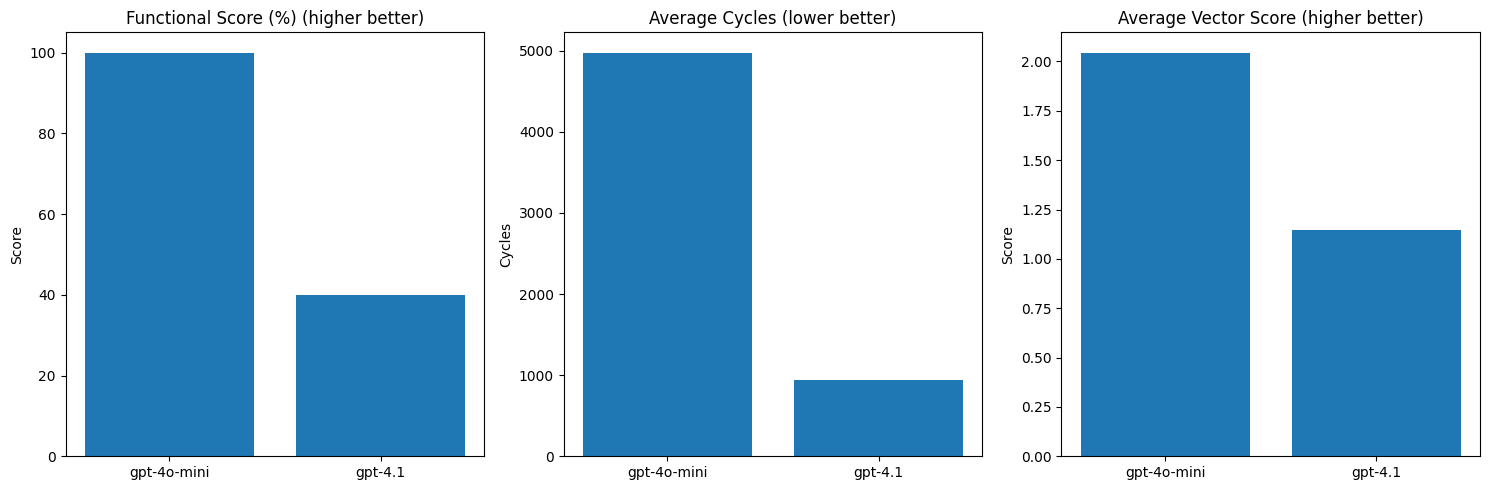

In [13]:
import matplotlib.pyplot as plt

models = list(scores.keys())
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Functional correctness
functional = [scores[model]['functional_score'] for model in models]
axes[0].bar(models, functional)
axes[0].set_title('Functional Score (%) (higher better)')
axes[0].set_ylabel('Score')

# Average runtime cycles
cycles = [scores[model]['avg_cycles'] for model in models]
axes[1].bar(models, cycles)
axes[1].set_title('Average Cycles (lower better)')
axes[1].set_ylabel('Cycles')

# Vector score
vector = [scores[model]['avg_vector_score'] for model in models]
axes[2].bar(models, vector)
axes[2].set_title('Average Vector Score (higher better)')
axes[2].set_ylabel('Score')

plt.tight_layout()
plt.show()

Note that GPT-4o-mini passes more tests, however the kernels that do pass tests from GPT-4.1 are better optimized. This is a common observation with LLM-based kernel code generation -- weak models write passable code, but don't try to optimize. Strong models try to optimize but oftentimes fail to pass the functional test because they hallucinate or make other mistakes.

In the next notebook we'll learn how to use retrieval augmented generation (RAG) to improve our generated code.

-----
Copyright© 2025 AMD, Inc SPDX-License-Identifier: MIT 